# Vetorização
O objetivo desta etapa é gerar uma matriz de features que incorpore o Corpus e outros atributos do dataset.

In [1]:
import time
import pickle
import warnings
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

random_state = 133
%matplotlib inline
sns.set(rc={'figure.figsize':(15,5)})
warnings.filterwarnings(action = 'ignore')
mpl.rcParams['agg.path.chunksize'] = 10000
pd.set_option('display.max_colwidth' , 100)

Carregar dataframe pre-processado:

In [15]:
df = pd.read_feather('df_preprocessado.feather').set_index('index')
print('dimensão do dataset:', df.shape)

dimensão do dataset: (5598785, 22)


## Preparação

In [17]:
df.dtypes

desc_eleicao                    category
uf                              category
ue                              category
partido                             int8
cargo                           category
candidato                          int32
documento                       category
data_despesa              datetime64[ns]
dia_despesa                        int64
semana_despesa            datetime64[ns]
mes_despesa               datetime64[ns]
fornecedor                         int32
setor_fornecedor                category
valor                            float64
tipo_despesa                    category
tipo_despesa_code                   int8
descricao_despesa                 object
descricao_wordcount                int64
descricao_charcount                int64
descricao_despesa_nulo             int64
documento_nulo                     int64
setor_fornecedor_nulo              int64
dtype: object

In [18]:
df.nunique()

desc_eleicao                   87
uf                             26
ue                           5296
partido                        38
cargo                           3
candidato                  409506
documento                       8
data_despesa                  651
dia_despesa                   651
semana_despesa                124
mes_despesa                    32
fornecedor                1356567
setor_fornecedor              821
valor                      111278
tipo_despesa                   35
tipo_despesa_code              35
descricao_despesa         1742194
descricao_wordcount            30
descricao_charcount           100
descricao_despesa_nulo          2
documento_nulo                  2
setor_fornecedor_nulo           2
dtype: int64

Vamos converter para números apenas as categorias com mais de 35 valores únicos:

In [19]:
df['uf_code'] = df['uf'].cat.codes.astype('str')
df['cargo_code'] = df['cargo'].cat.codes.astype('str')
df['documento_code'] = df['documento'].cat.codes.astype('str')
df['tipo_despesa_code'] = df['tipo_despesa'].cat.codes.astype('str')

Aplicaremos a técina de one-hot encoding para transformar as categoria mais frequentes dos atributos categóricos num novo atributo de valor zero ou um.

Os atributos numéricos serão normalizados.

Os atributos de data serão convertidos em atributos numéricos e normalizados.
### Normalização de variáveis

In [21]:
colunas_matriz = ['dia_despesa', 'valor', 'tipo_despesa_code', 'descricao_wordcount', 'descricao_charcount',
                  'descricao_despesa_nulo', 'documento_nulo', 'setor_fornecedor_nulo', 'uf_code',
                  'cargo_code', 'documento_code']
df[colunas_matriz].dtypes

dia_despesa                 int64
valor                     float64
tipo_despesa_code          object
descricao_wordcount         int64
descricao_charcount         int64
descricao_despesa_nulo      int64
documento_nulo              int64
setor_fornecedor_nulo       int64
uf_code                    object
cargo_code                 object
documento_code             object
dtype: object

In [23]:
df_matriz = df[colunas_matriz]
df_matriz.sample(4)

dia_despesa  valor tipo_despesa_code  descricao_wordcount  \
index                                                                
1755055         2200  100.0                 4                    3   
214405          2200  175.0                29                    3   
3233313         2191    6.5                13                    2   
352142          2191   25.0                26                    4   

         descricao_charcount  descricao_despesa_nulo  documento_nulo  \
index                                                                  
1755055                   21                       0               0   
214405                    24                       0               0   
3233313                   15                       0               1   
352142                    29                       0               0   

         setor_fornecedor_nulo uf_code cargo_code documento_code  
index                                                             
1755055                      0      22          1              4  
214405                       0      22          1              4  
3233313                      1       4          1              0  
352142                       0       4          1              4

In [26]:
escalador_dia_despesa = MinMaxScaler()
escalador_descricao_charcount = MinMaxScaler()
escalador_descricao_wordcount = MinMaxScaler()
escalador_valor = MinMaxScaler()
escalador_descricao_despesa_nulo = MinMaxScaler()
escalador_documento_nulo = MinMaxScaler()
escalador_setor_fornecedor_nulo = MinMaxScaler()


df_matriz['dia_despesa'] = escalador_dia_despesa.fit_transform(df_matriz[['dia_despesa']].values)
df_matriz['descricao_charcount'] = escalador_descricao_charcount.fit_transform(df_matriz[['descricao_charcount']].values)
df_matriz['descricao_wordcount'] = escalador_descricao_wordcount.fit_transform(df_matriz[['descricao_wordcount']].values)
df_matriz['valor'] = escalador_valor.fit_transform(df_matriz[['valor']].values)
df_matriz['descricao_despesa_nulo'] = escalador_descricao_despesa_nulo.fit_transform(df_matriz[['descricao_despesa_nulo']].values)
df_matriz['documento_nulo'] = escalador_documento_nulo.fit_transform(df_matriz[['documento_nulo']].values)
df_matriz['setor_fornecedor_nulo'] = escalador_setor_fornecedor_nulo.fit_transform(df_matriz[['setor_fornecedor_nulo']].values)

In [27]:
df_matriz.head()

dia_despesa     valor tipo_despesa_code  descricao_wordcount  \
index                                                                 
0         0.760558  0.000002                 2               0.1250   
1         0.760558  0.000002                 2               0.1250   
2         0.760558  0.000003                 2               0.1250   
3         0.760558  0.000003                 2               0.0625   
4         0.760558  0.000004                 2               0.1250   

       descricao_charcount  descricao_despesa_nulo  documento_nulo  \
index                                                                
0                 0.313131                     0.0             0.0   
1                 0.303030                     0.0             0.0   
2                 0.313131                     0.0             0.0   
3                 0.161616                     0.0             0.0   
4                 0.303030                     0.0             0.0   

       setor_fornecedor_nulo uf_code cargo_code documento_code  
index                                                           
0                        1.0      21          1              5  
1                        1.0      21          1              5  
2                        1.0      21          1              5  
3                        1.0      21          1              5  
4                        1.0      21          1              5

### One-hot encoding
Agora transformamos os atributos categóricos em colunas de 0 e 1

In [28]:
df_onehot = pd.get_dummies(df_matriz, sparse=True)
df_onehot.shape

(5598785, 79)

In [29]:
df_onehot.sample(5, random_state= random_state)

dia_despesa         valor  descricao_wordcount  descricao_charcount  \
index                                                                          
3454538     0.763700  2.275000e-06              0.00000             0.080808   
309959      0.773124  1.875000e-07              0.06250             0.212121   
508374      0.773124  4.800500e-06              0.03125             0.171717   
4194082     0.774520  1.000000e-06              0.12500             0.434343   
5140073     0.765794  7.500000e-05              0.28125             0.606061   

         descricao_despesa_nulo  documento_nulo  setor_fornecedor_nulo  \
index                                                                    
3454538                     0.0             0.0                    0.0   
309959                      0.0             0.0                    0.0   
508374                      0.0             0.0                    0.0   
4194082                     0.0             0.0                    0.0   
5140073                     0.0             0.0                    1.0   

         tipo_despesa_code_0  tipo_despesa_code_1  tipo_despesa_code_10  ...  \
index                                                                    ...   
3454538                    0                    0                     0  ...   
309959                     0                    0                     0  ...   
508374                     0                    0                     0  ...   
4194082                    0                    0                     0  ...   
5140073                    0                    0                     0  ...   

         cargo_code_1  cargo_code_2  documento_code_0  documento_code_1  \
index                                                                     
3454538             1             0                 0                 0   
309959              0             0                 0                 0   
508374              1             0                 0                 1   
4194082             1             0                 0                 0   
5140073             1             0                 0                 0   

         documento_code_2  documento_code_3  documento_code_4  \
index                                                           
3454538                 0                 0                 1   
309959                  0                 0                 1   
508374                  0                 0                 0   
4194082                 0                 0                 1   
5140073                 0                 0                 0   

         documento_code_5  documento_code_6  documento_code_7  
index                                                          
3454538                 0                 0                 0  
309959                  0                 0                 0  
508374                  0                 0                 0  
4194082                 0                 0                 0  
5140073                 1                 0                 0  

[5 rows x 79 columns]

In [30]:
pickle.dump(df_onehot, open("datasetFeatMatrix_oneHot.pickle", "wb"), protocol=4)

### Experimento

In [31]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=3, max_no_improvement=10, verbose=0,
                      random_state = random_state)
mbk.fit(df_onehot)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=133,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [32]:
inertia = mbk.inertia_
silhouette = silhouette_score(df_onehot, mbk.labels_, sample_size = 1000, random_state = random_state)

In [33]:
print(inertia, silhouette) 

10414328.821874376 0.17489185409126753


### Represenção em 2D

In [37]:
def representar_2D (X, model):
    n_clusters = 8
    # #############################################################################
    # Compute clustering with MiniBatchKMeans         
            
    t0 = time.time()
    mbk.fit(X)
    t_mini_batch = time.time() - t0
    
    trunc = TruncatedSVD(n_components=2, random_state=random_state)
    try:
        X_trunc = trunc.fit_transform(X.todense())
    except:
        X_trunc = trunc.fit_transform(X)
    
    
    silhouette = silhouette_score(X, model.labels_, sample_size = 1000, random_state = random_state)

    df_X_trunc = pd.DataFrame(X_trunc, columns=["x", "y"])
    df_X_trunc['label'] = model.labels_
    df_X_trunc.label = df_X_trunc.label.astype(str) #.str.slice(stop=3)
    # #############################################################################
    # Plot result
    fig, ax = plt.subplots(figsize=(15, 4))
    print ('inertia: %.2f\nsilhouette: %.4f' %
             ( model.inertia_, silhouette))
    
    sns.scatterplot('x', 'y', hue = 'label', data=df_X_trunc, palette=sns.color_palette("Set2", n_clusters))
    ax.set_title('MiniBatchKMeans')
    #ax.set_xticks(())
    #ax.set_yticks(())  

    plt.show()
    return df_X_trunc

Visualizando os dados

inertia: 10414328.82
silhouette: 0.1749


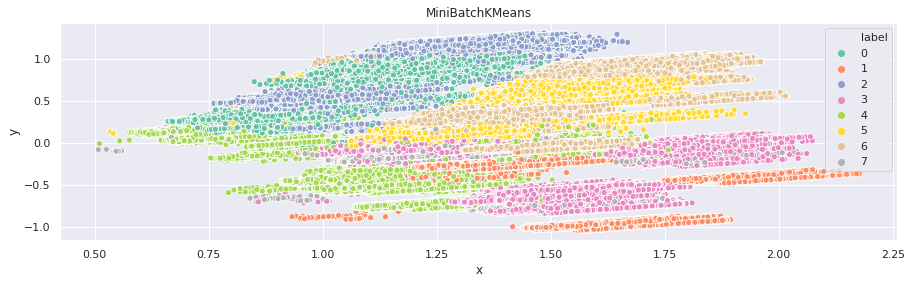

In [38]:
_ = representar_2D(X = df_onehot, model = mbk)